# Spatiotemporal machine learning in Python pt. 1 
## Content

1. [Random Forest](#rf)
2. [Random Forest with hyperparameter optimization](#rf_hp)
3. [Random Forest with probabilities and hyperparameter optimization](#rf_hp_prob) 
4. [Random Forest with probabilities, hyperparameter optimization and feature reduction](#rf_hp_prod_fr)

In this tutorial, we will use the overlaid points to train a ML-model and predict the land cover (LC), using the LandMapper class.

The training step will use elevation, slope, landsat (7 spectral bands, 4 seasons and 3 percentiles per year) and night light (VIIRS Night Band) data to predict the LC classes. 

First, let’s import the necessary modules

In [ ]:
# To work with local eumap code
import sys
sys.path.append('../../eumap')

import os
import gdal
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from eumap.mapper import LandMapper

import warnings
warnings.filterwarnings('ignore')

We are loading the data

In [2]:
data_dir = '../../data'

fn_points = Path(os.getcwd()).joinpath(data_dir, 'land_cover_samples.gpkg')
points = gpd.read_file(fn_points)

points

,uid,sample_id,lucas,survey_date,clc_class,confidence,tile_id,dtm_cost.distance.to.coast_gedi.grass.gis_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,dtm_slope.percent_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,...,lcv_thermal_landsat.glad.ard_p25_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p50_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p25_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.09.13...12.01_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.06.25...09.12_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,clc_class_name,survey_year,geometry
0,1,1043933,False,2000-06-30T00:00:00,112.0,85.0,14580,16.0,3.0,179.0,...,182.0,184.0,184.0,184.0,182.0,184.0,185.0,Discontinuous urban fabric,2000,POINT (4029228.465 3213721.960)
1,2,1044143,False,2000-06-30T00:00:00,112.0,85.0,14580,17.0,9.0,174.0,...,182.0,185.0,185.0,184.0,184.0,185.0,185.0,Discontinuous urban fabric,2000,POINT (4026356.067 3226174.095)
2,3,1045508,False,2000-06-30T00:00:00,142.0,85.0,14580,26.0,5.0,184.0,...,182.0,182.0,182.0,182.0,182.0,182.0,182.0,Sport and leisure facilities,2000,POINT (4040332.136 3232426.480)
3,4,1047826,False,2000-06-30T00:00:00,121.0,85.0,14580,20.0,2.0,179.0,...,181.0,184.0,184.0,184.0,181.0,184.0,184.0,Industrial or commercial units,2000,POINT (4043139.050 3210780.235)
4,5,1047851,False,2000-06-30T00:00:00,121.0,85.0,14580,18.0,18.0,167.0,...,183.0,184.0,184.0,183.0,183.0,184.0,185.0,Industrial or commercial units,2000,POINT (4031326.376 3214389.790)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1987,1969703,False,2018-06-30T00:00:00,324.0,85.0,5606,30.0,65.0,208.0,...,188.0,189.0,188.0,190.0,190.0,190.0,189.0,Transitional woodland-shrub,2018,POINT (5529944.553 1799948.030)
1987,1988,1973479,False,2018-06-30T00:00:00,411.0,85.0,5606,1.0,5.0,184.0,...,188.0,187.0,186.0,189.0,189.0,188.0,187.0,Inland marshes,2018,POINT (5549833.044 1787886.590)
1988,1989,1973669,False,2018-06-30T00:00:00,512.0,85.0,5606,77.0,5.0,184.0,...,185.0,183.0,183.0,186.0,187.0,184.0,184.0,Water bodies,2018,POINT (5540375.986 1788516.395)
1989,1990,2229815,False,2018-06-30T00:00:00,242.0,85.0,5606,97.0,19.0,169.0,...,188.0,188.0,188.0,188.0,188.0,190.0,189.0,Complex cultivation patter,2018,POINT (5529408.859 1782531.095)


Lets explore some of the columns using a barplot

In [3]:
def barplot_counts(dataset, column_name):

    arr_counts = dataset.value_counts(column_name)
    years = arr_counts.index.values
    counts = np.array(arr_counts)
    
    int_x = False
    if isinstance(years[0], np.int64):
        years_all = range(min(years), max(years)+1)
        int_x = True
    else: 
        years_all = years
        
    if len(years) < 5:
        years = [str(item) for item in years]
        years_all = years
        
    fig, ax = plt.subplots(figsize = (10,4))
    ax.bar(x = years, height = counts);
    if int_x:
        ax.set_xticks(years_all);
    ax.set_xticklabels(years_all, rotation=90)
    ax.set_title('Training point count')
    ax.set_xlabel('options');
    ax.set_ylabel('# of training points');

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


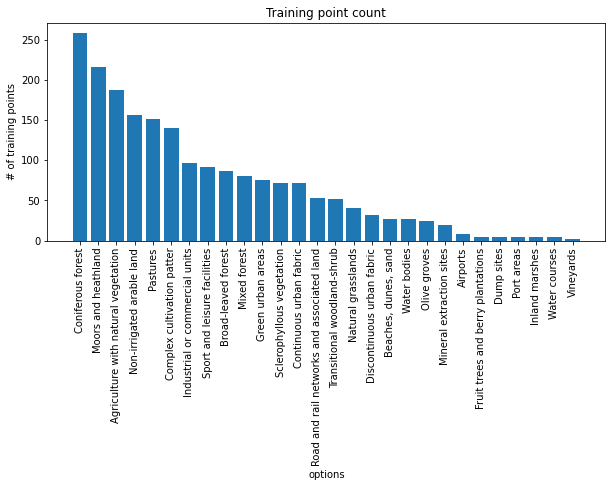

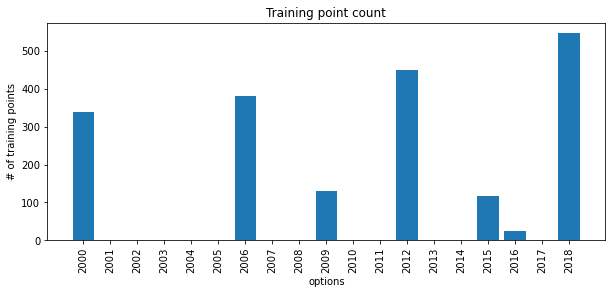

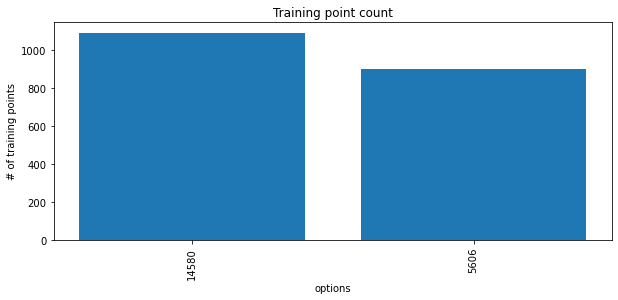

In [4]:
plot_cols = ['clc_class_name', 'survey_year','tile_id',]


for colname in plot_cols:
    barplot_counts(points,colname)

For this exercise we will select only one year of data

In [5]:
points_2018 = points[points['survey_year'] == 2018]

In [6]:
# save intermediate data
# points.to_file(os.path.join(data_dir,'land_cover_samples_v0.3.gpkg'), driver = 'GPKG')

## Step 1: Random Forest (train and prediction) <a id='rf'></a>
[top](#top)

To map the land cover we will use the LandMapper class, which will train a ML-model and do spatial predictions. This class will receive a model implementation compatible with sklearn (e.g. RandomForest, SVC, KerasClassifier, XGBClassifier).

In the remote sensing area the precision was renamed to Producer’s Accuracy (the producer of the classification is interested in understand how well a specific area on Earth can be mapped) and the recall was renamed to User’s Accuracy (the user of classification is interested in check how well the map represents what is really on the ground) (Story, 1986).

The evaluation metric will be calculated using a cross validation strategy, using diferente parts of samples to train and validate the model. Here we will use a 5-fold cv, but others validation strategies are also supported by LandMapper class.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=5)

min_samples_per_class = 0.05
cv = 5

feat_col_prfxs = [
    'dtm', 
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'


landmapper = LandMapper(points=points_2018,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        cv=cv,
                        min_samples_per_class=min_samples_per_class,
                        verbose = True)

[15:02:47] Removing 206 samples (clc_class in [321. 222. 111. 131. 122. 141. 331. 112. 142. 121. 123. 124. 313. 512.
 223. 221. 132. 323. 324. 411.]) due min_samples_per_class condition (< 0.05)
[15:02:47] Transforming clc_class:
[15:02:47]  -Original classes: [211. 231. 242. 243. 311. 312. 322.]
[15:02:47]  -Transformed classes: [0 1 2 3 4 5 6]


We can use sklearn methods on the landmapper class, for example we can get the model parameters:

In [13]:
landmapper.estimator_list[0].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
landmapper.train()

[15:02:48] Calculating evaluation metrics
[15:02:48] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [15]:
print(f'Overall accuracy: {landmapper.eval_metrics["overall_acc"] * 100:.2f}%\n\n')
print(landmapper.eval_report)

Overall accuracy: 47.51%


              precision    recall  f1-score   support

           0       0.59      0.57      0.58        40
           1       0.68      0.67      0.68        39
           2       0.18      0.20      0.19        35
           3       0.22      0.30      0.25        47
           4       0.32      0.34      0.33        35
           5       0.68      0.59      0.63        91
           6       0.60      0.48      0.54        54

    accuracy                           0.48       341
   macro avg       0.47      0.45      0.46       341
weighted avg       0.50      0.48      0.49       341



In [16]:
# create dictionary for matching class codes to descriptions for plotting
clc_classes_list = points['clc_class'].unique()
clc_class_name_dict = {int(clc_class): points[points['clc_class'] == clc_class]['clc_class_name'].reset_index(drop=True)[0] for clc_class in clc_classes_list}

Verifing the label order:
 - 0 => 243: Agriculture with natural vegetation
 - 1 => 311: Broad-leaved forest
 - 2 => 322: Moors and heathland
 - 3 => 312: Coniferous forest
 - 4 => 242: Complex cultivation patter
 - 5 => 211: Non-irrigated arable land
 - 6 => 231: Pastures


Confusion Matrix:


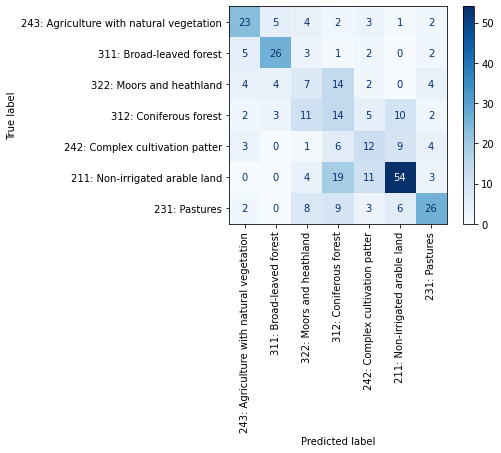

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# create labels dict
labels = {f'{int(value)}: {clc_class_name_dict[value]}' for value in landmapper.target_classes['original']}

estimator = landmapper.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

print("\n\nConfusion Matrix:")
confusion_matrix = landmapper.eval_metrics['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
disp.plot(cmap='Blues', xticks_rotation='vertical');

We can use landmapper to save and load our models

In [18]:
fn_joblib = os.path.join(data_dir, 'landmapper_saved_instance.lz4')
landmapper.save_instance(fn_joblib, no_train_data=True, compress='lz4')

fn_joblib

[15:02:59] Removing pts attribute
[15:02:59] Removing features attribute
[15:02:59] Removing target attribute
[15:02:59] Removing samples_weight attribute
[15:02:59] Removing cv_groups attribute


'../../data/landmapper_saved_instance.lz4'

We can reset the instance and load model to do predictions

In [ ]:
os._exit(00) # resets instance !!

In [19]:
import sys
sys.path.append('../../eumap')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from eumap.mapper import LandMapper

import warnings
warnings.filterwarnings('ignore')

data_dir = '../../data'

To allow for spacetime models we can pass a ``dict_layers_newnames`` that matches our naming convention and allows us to differentiate between data of specific years.
Here we present a custom function that corresponds to our naming convention and that can be used to generate the new names:

In [20]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 14580

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_14580


In [48]:
from eumap.misc import find_files

timeless_rasters = []

for name in landmapper.feature_cols:
    raster_files = find_files(raster_dir, f'{name}*')
    if len(raster_files):
        timeless_rasters += raster_files

timeless_rasters

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_cost.distance.to.coast_gedi.grass.gis_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_slope.percent_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_openp_gedi.saga.gis_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_openn_gedi.saga.gis_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_hillshade.a315_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_elev.lowestmode_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 Posix

In [49]:
from eumap.misc import find_files

temporal_rasters = []
year = 2018

for prf in feat_col_prfxs:
    if 'lcv' in prf:
        temporal_rasters += find_files(raster_dir, f'{prf}*..{year}*')

temporal_rasters[0:5]

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.03.21..2018.06.24_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.09.13..2018.12.01_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_blue_landsat.glad.ard_p50_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1.tif')]

In [50]:
fn_layers = timeless_rasters.extend(temporal_rasters)
fn_layers = timeless_rasters

In [52]:
dict_layers_newnames = {}
for tr in temporal_raster:
    filename = tr.stem
    newname = filename.replace(str(year),'') \
                      .replace(str(year-1),'')
    dict_layers_newnames[newname] = filename

dict_layers_newnames[list(dict_layers_newnames.keys())[0]]

'lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1'

we will load landmapper instance to perform predictions

In [53]:
landmapper = LandMapper.load_instance('../../data/landmapper_saved_instance.lz4')

In [54]:
import glob

# define output data location
fn_output = os.path.join(data_dir, f'lc_tile_{TILE_ID}_{year}.tif')

landmapper.verbose = True

output_fn_files = landmapper.predict(fn_layers=fn_layers, 
                                     fn_output=fn_output, 
                                     dict_layers_newnames = dict_layers_newnames, 
                                     allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

[15:13:39] Reading 93 raster files using 4 workers
[15:13:44] Renaming lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1 to lcv_blue_landsat.glad.ard_p25_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1
[15:13:44] Renaming lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.03.21..2018.06.24_eumap_epsg3035_v1.1 to lcv_blue_landsat.glad.ard_p25_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1
[15:13:44] Renaming lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1 to lcv_blue_landsat.glad.ard_p25_30m_0..0cm_.06.25...09.12_eumap_epsg3035_v1.1
[15:13:44] Renaming lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2018.09.13..2018.12.01_eumap_epsg3035_v1.1 to lcv_blue_landsat.glad.ard_p25_30m_0..0cm_.09.13...12.01_eumap_epsg3035_v1.1
[15:13:44] Renaming lcv_blue_landsat.glad.ard_p50_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1 to lcv_blue_landsat.glad.ard_p50_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1
[15:13:44] Renaming lcv_blue_lands

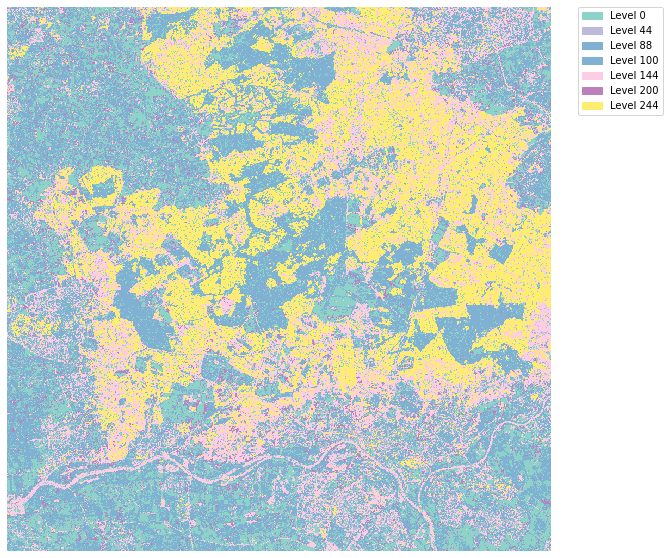

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

import rasterio as rio

arr_pred = rio.open(output_fn_files[0]).read()

# create some data
data =arr_pred.reshape(1000,1000)
# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(10,10))
im = plt.imshow(data, interpolation='none', cmap = 'Set3')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.axis('off')

plt.grid(True)
plt.show()

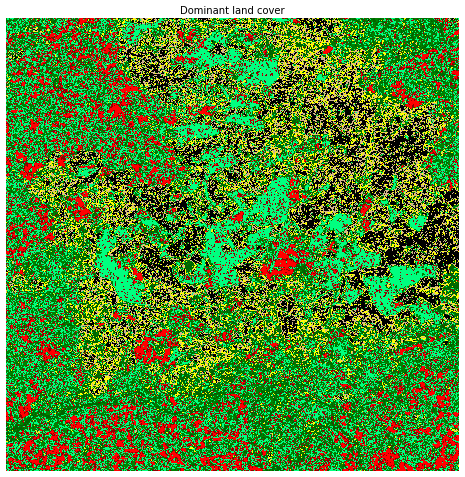

In [56]:
from eumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap



# create labels dict
labels = {f'{int(value)}: {clc_class_name_dict[value]}' for value in landmapper.target_classes['original']}
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "black"])
plot_rasters(output_fn_files[0], cmaps = colors, titles = 'Dominant land cover', dpi = 60)




In [57]:
lc_classes = landmapper.target_classes['original']
pixel_values = landmapper.target_classes['transformed']

print("Mapped land cover classes")
for lab, l, p, c in zip(labels, lc_classes, pixel_values, colors.colors):
    print(f'- {l:.0f} => pixel value {p} ({c}) - \t\t{lab}')

Mapped land cover classes
- 211 => pixel value 0 (red) - 		243: Agriculture with natural vegetation
- 231 => pixel value 1 (darkred) - 		311: Broad-leaved forest
- 242 => pixel value 2 (springgreen) - 		322: Moors and heathland
- 243 => pixel value 3 (green) - 		312: Coniferous forest
- 311 => pixel value 4 (darkgreen) - 		242: Complex cultivation patter
- 312 => pixel value 5 (yellow) - 		211: Non-irrigated arable land
- 322 => pixel value 6 (tan) - 		231: Pastures


## Step 2: Random Forest with hyperparameter optimization <a id='rf_hp'></a>
[top](#top)

LandMapper can be used with a BaseSearchCV implementation to find the best hyperparamenter for the specified model. For the hyperparameter optimization it’s possible to select diferent scoring metrics and hyperparameter range values. In this example we will use the f1-score, that is basically a weighted average between the precision and recall. It’s possible use other evaluation metrics modifing ou creating a new python function, that will be passed as parameter for the LandMapper class.

In [25]:
from sklearn.metrics import f1_score

def f1_scorer(clf, X, y_true):
    y_pred = clf.predict(X)
    error = f1_score(y_true, y_pred, average='weighted')
    return error


In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=5)

min_samples_per_class = 0.05
cv = 5

feat_col_prfxs = [
    'dtm', 
    'lcv_blue_landsat.glad.ard_',
    'lcv_green_landsat.glad.ard_',
    'lcv_red_landsat.glad.ard_',
    'lcv_nir_landsat.glad.ard_',
    'lcv_swir1_landsat.glad.ard_',
    'lcv_swir2_landsat.glad.ard_',
    'lcv_thermal_landsat.glad.ard_',
] # add prefixes for spacetime variables!

target_col = 'clc_class'

# hyperparameter optimization
hyperpar = GridSearchCV(
    estimator = estimator,
    param_grid = {
     'max_depth': [5, None],
     'max_features': [0.5, None],
     'n_estimators': [5,20,30,50]
    }
)



Let’s optimize and train the model:

In [59]:
landmapper = LandMapper(points=points_2018,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        hyperpar_selection = hyperpar,
                        cv=cv,
                        min_samples_per_class=min_samples_per_class,
                        verbose = True)

[15:17:34] Removing 206 samples (clc_class in [321. 222. 111. 131. 122. 141. 331. 112. 142. 121. 123. 124. 313. 512.
 223. 221. 132. 323. 324. 411.]) due min_samples_per_class condition (< 0.05)
[15:17:34] Transforming clc_class:
[15:17:34]  -Original classes: [211. 231. 242. 243. 311. 312. 322.]
[15:17:34]  -Transformed classes: [0 1 2 3 4 5 6]


In [60]:
landmapper.train()

[15:17:34] Optimizing hyperparameters for RandomForestClassifier
[15:17:45]  -0.52217 (+/-0.14923) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 5}
[15:17:45]  -0.51620 (+/-0.13165) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 20}
[15:17:45]  -0.51330 (+/-0.14534) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 30}
[15:17:45]  -0.50435 (+/-0.14151) from {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 50}
[15:17:45]  -0.44872 (+/-0.10512) from {'max_depth': 5, 'max_features': None, 'n_estimators': 5}
[15:17:45]  -0.52485 (+/-0.11209) from {'max_depth': 5, 'max_features': None, 'n_estimators': 20}
[15:17:45]  -0.52796 (+/-0.10860) from {'max_depth': 5, 'max_features': None, 'n_estimators': 30}
[15:17:45]  -0.50443 (+/-0.12464) from {'max_depth': 5, 'max_features': None, 'n_estimators': 50}
[15:17:45]  -0.44864 (+/-0.12621) from {'max_depth': None, 'max_features': 0.5, 'n_estimators': 5}
[15:17:45]  -0.52506 (+/-0.14862) from {'max_depth': None,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:17:46] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Let’s understand what happened here: 1. Diferent combinations of hyperparameters where evaluated 2. The best one was chosen and all the samples were cross validated to derive other classification metrics 3. A final model were trained using all the samples, without cv. This model will be used to classify the land-cover in future prediction

We can check other classification metrics for the best classification models

In [61]:
print(f'Overall accuracy: {landmapper.eval_metrics["overall_acc"] * 100:.2f}%\n\n')
print(landmapper.eval_report)

Overall accuracy: 50.44%


              precision    recall  f1-score   support

           0       0.50      0.53      0.51        40
           1       0.71      0.69      0.70        39
           2       0.33      0.29      0.31        35
           3       0.23      0.23      0.23        47
           4       0.44      0.46      0.45        35
           5       0.62      0.69      0.65        91
           6       0.52      0.44      0.48        54

    accuracy                           0.50       341
   macro avg       0.48      0.48      0.48       341
weighted avg       0.50      0.50      0.50       341



… and the complete confusion matrix:



Confusion Matrix:


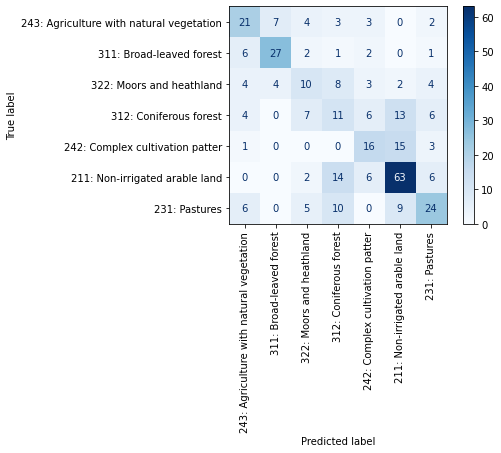

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

estimator = landmapper.estimator_list[0]
print("\n\nConfusion Matrix:")
confusion_matrix = landmapper.eval_metrics['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
disp.plot(cmap='Blues', xticks_rotation='vertical');

## Step 3: Random Forest with probabilities and hyperparameter optimization <a id='rf_hp_prob'></a>

(train and prediction - here we find log_loss as metric)
[top](#top)

Considering that a probability output provides diferent levels of classification for the target classes, it’s recommended a diferent evaluation metric for the the hyperparameter optimization. Here we choosen log_loss(logistic loss or cross-entropy loss), however you can find more options in scikit-learn - Classification Metrics (hinge_loss, brier_score_loss).

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by -1 the returned error.

In [63]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1


We will use the same classification algorithm, hyperparameter possibilities and cv strategy. Now let’s create a new instance for the LandMapper class passing one aditional parameter: * pred_method: The predict_proba will change the model output for a lc-class probabilities.

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

weight_col = 'confidence'

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'min_samples_leaf': [1, 5],
     'max_depth': [5, None],
     'max_features': [0.5, 'auto'],
     'n_estimators': [20,30,50]
    }
)

landmapper_prob = LandMapper(points=points_2018,
                        feat_col_prfxs = feat_col_prfxs,
                        target_col = target_col,
                        estimator = estimator,
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        pred_method='predict_proba',
                        weight_col=weight_col,
                        verbose = True)

[15:17:58] Removing 206 samples (clc_class in [321. 222. 111. 131. 122. 141. 331. 112. 142. 121. 123. 124. 313. 512.
 223. 221. 132. 323. 324. 411.]) due min_samples_per_class condition (< 0.05)
[15:17:58] Transforming clc_class:
[15:17:58]  -Original classes: [211. 231. 242. 243. 311. 312. 322.]
[15:17:58]  -Transformed classes: [0 1 2 3 4 5 6]


Notice that the original classes were remaped for a sequential class values using LabelEncoder, which can be accessed in the property target_le:

In [65]:
landmapper_prob.target_le

LabelEncoder()

Time to run (If it’s taking too long try to reduce the hyperparameters possibilities and/or the cv=2):

In [66]:
landmapper_prob.train()

[15:18:00] Optimizing hyperparameters for RandomForestClassifier
[15:18:12]  1.42164 (+/-0.44397) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 20}
[15:18:12]  1.53249 (+/-0.71009) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 30}
[15:18:12]  1.40268 (+/-0.44347) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 50}
[15:18:12]  1.72562 (+/-0.84639) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 20}
[15:18:12]  1.58042 (+/-0.83711) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 30}
[15:18:12]  1.40474 (+/-0.41139) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 50}
[15:18:12]  1.44628 (+/-0.36499) from {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 20}
[15:18:12]  1.41514 (+/-0.68979) from {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:18:13] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


Now let’s take a look in the classification report.

In [67]:
print(f'Log loss: {landmapper_prob.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_prob.eval_report)


Log loss: 1.389


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.3913     0.5475   0.3050        0.4750              0.4750         40
1  1.7331     0.6900   0.3525        0.7692              0.7692         39
2  1.8386     0.2928   0.2549        0.3714              0.3714         35
3  1.9667     0.2462   0.3148        0.2766              0.2766         47
4  1.4105     0.3483   0.3528        0.4286              0.4286         35
5  0.8449     0.6487   0.3953        0.6703              0.6703         91
6  1.2493     0.6502   0.2796        0.5370              0.5370         54

Total                                                                     341



Let’s understand this report.

Using the cv result, the LandMapper calculated the log_loss and the pr_auc (area under the precision recall curve) for each class. The pr_auc information was used to choose the best probability value to derive a hard classification output, balancing the precision (producer’s accuracy or the class understimation) and recall (user’s accuracy or the class overestimation), thus minimizing the bias in the land cover area estimation. For more infomation about the precision recall curve access this link.

All the probabilities metrics are available through the prob_metrics property

In [68]:
list(landmapper_prob.prob_metrics.keys())


['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

…and it’s possible to use the raw cv results to derive other evaluation metrics as hinge_loss:

In [69]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probability values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper_prob.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper_prob.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 7.520%
 - 1: 4.954%
 - 2: 8.065%
 - 3: 11.247%
 - 4: 7.851%
 - 5: 12.371%
 - 6: 9.375%


Now let's make a prediction and generate probability values for each class, first we find all the data that we need and put it in a list: 

In [70]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 14580

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

from eumap.misc import find_files

timeless_rasters = []

for name in landmapper.feature_cols:
    raster_files = find_files(raster_dir, f'{name}*')
    if len(raster_files):
        timeless_rasters += raster_files


from eumap.misc import find_files

temporal_rasters = []
year = 2018

for prf in feat_col_prfxs:
    if 'lcv' in prf:
        temporal_rasters += find_files(raster_dir, f'{prf}*..{year}*')

fn_layers = timeless_rasters.extend(temporal_rasters)
fn_layers = timeless_rasters

dict_layers_newnames = {}
for tr in temporal_raster:
    filename = tr.stem
    newname = filename.replace(str(year),'') \
                      .replace(str(year-1),'')
    dict_layers_newnames[newname] = filename

dict_layers_newnames[list(dict_layers_newnames.keys())[0]]

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_14580


'lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2017.12.02..2018.03.20_eumap_epsg3035_v1.1'

Then we can use the landmapper class to make the predictions, now we get multiple outputs: 

In [71]:
landmapper_prob.verbose = False

output_fn_files = landmapper_prob.predict(fn_layers=fn_layers, 
                                     fn_output=fn_output, 
                                     dict_layers_newnames = dict_layers_newnames, 
                                     allow_additional_layers=True)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {output_fn_file}')

Output files:
 - ../../data/lc_tile_14580_2018_b1.tif
 - ../../data/lc_tile_14580_2018_b2.tif
 - ../../data/lc_tile_14580_2018_b3.tif
 - ../../data/lc_tile_14580_2018_b4.tif
 - ../../data/lc_tile_14580_2018_b5.tif
 - ../../data/lc_tile_14580_2018_b6.tif
 - ../../data/lc_tile_14580_2018_b7.tif
 - ../../data/lc_tile_14580_2018_hcl.tif
 - ../../data/lc_tile_14580_2018_hcl_prob.tif


We can plot the dominant land cover using the plotter class: 

Mapped land cover classes
 - 211 => pixel value 0 (red)
 - 231 => pixel value 1 (darkred)
 - 242 => pixel value 2 (springgreen)
 - 243 => pixel value 3 (green)
 - 311 => pixel value 4 (darkgreen)
 - 312 => pixel value 5 (yellow)
 - 322 => pixel value 6 (tan)


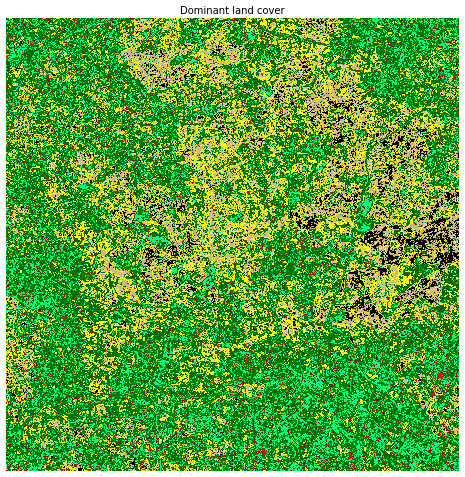

In [72]:
from eumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper_prob.target_classes['original']
pixel_values = landmapper_prob.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "black"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover', dpi = 60)

Now we can also plot the probabilities for each class and get some information about where the model is quite certain and where it is not: 

Verifing the label order:
 - 0 => 243: Agriculture with natural vegetation
 - 1 => 311: Broad-leaved forest
 - 2 => 322: Moors and heathland
 - 3 => 312: Coniferous forest
 - 4 => 242: Complex cultivation patter
 - 5 => 211: Non-irrigated arable land
 - 6 => 231: Pastures


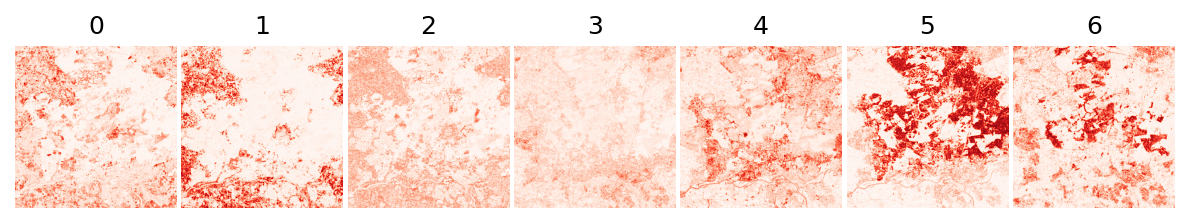

In [73]:
import numpy as np
from eumap.plotter import plot_rasters

estimator = landmapper_prob.estimator_list[0]
print("Verifing the label order:")
for label, cl in zip(labels, estimator.classes_):
    print(f' - {cl:.0f} => {label}')

lc_classes = [ int(c) for c in landmapper_prob.target_classes['transformed']]

plot_rasters(*output_fn_files[0:7], cmaps='Reds', titles=lc_classes ,vertical_layout=False)

## Step 4: Random Forest with probabilities, hyperparameter optimization and feature reduction <a id='rf_hp_prod_fr'></a>
[top](#top)

The LandMapper is fully compatible with scikit-learn, supporting any BaseEstimator and Pipeline implementations.

To demonstrate it, we will develop from scratch a simple random feature selection strategy, which will randomly reduce the number of input features before the training step.

In [74]:
from numpy.random import default_rng
from sklearn.base import BaseEstimator, TransformerMixin

class RandomFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, n_features = 10, seed = 0):
        self.n_features = n_features
        self.rng = default_rng()
        self.seed = seed

    def fit(self, X, y):
        n_features = X.shape[1]
        self.rand_features = self.rng.choice(n_features, size=self.n_features, replace=False)
        return self

    def transform(self, X):
        return X[:,self.rand_features]

Now let’s define the expected number of features, changing the input seed to produce diferent subsets. The passthrough will indicate to the pipeline just move foward to the next step.

In [75]:
feature_sel = [
    RandomFeatureSelector(n_features=60, seed = 0),
    RandomFeatureSelector(n_features=70, seed = 0),
    RandomFeatureSelector(n_features=80, seed = 0),
    RandomFeatureSelector(n_features=60, seed = 1),
    RandomFeatureSelector(n_features=70, seed = 1),
    RandomFeatureSelector(n_features=80, seed = 1),
    'passthrough'
]


This time we will define our estimators as pipeline, indicating the feature_sel step before them

In [76]:
from sklearn.pipeline import Pipeline

estimator_rf = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85))
])

…and adding the feature_sel possibilities as a property in our hyperparameter optimization class (GridSearchCV):

In [77]:
hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__max_depth': [5, None],
     'estimator__max_features': [0.5, None]
    }
)

… and LandMapper parameters:

In [78]:
cv = 2

landmapper_feat_sel = LandMapper(points=points_2018,
                                feat_col_prfxs = feat_col_prfxs,
                                target_col = target_col,
                                estimator = estimator_rf,
                                hyperpar_selection = hyperpar_rf,
                                min_samples_per_class = min_samples_per_class,
                                cv = cv,
                                pred_method='predict_proba',
                                verbose = True)

landmapper_feat_sel.train()

[15:19:44] Removing 206 samples (clc_class in [321. 222. 111. 131. 122. 141. 331. 112. 142. 121. 123. 124. 313. 512.
 223. 221. 132. 323. 324. 411.]) due min_samples_per_class condition (< 0.05)
[15:19:44] Transforming clc_class:
[15:19:44]  -Original classes: [211. 231. 242. 243. 311. 312. 322.]
[15:19:44]  -Transformed classes: [0 1 2 3 4 5 6]
[15:19:44] Optimizing hyperparameters for Pipeline
Fitting 2 folds for each of 28 candidates, totalling 56 fits
[15:20:01]  3.21862 (+/-3.03914) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60)}
[15:20:01]  2.89793 (+/-2.32314) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=70)}
[15:20:01]  2.49595 (+/-1.67358) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=80)}
[15:20:01]  3.58396 (+/-3.85454) from {'estimator__max_depth': 5, 'estimator__max_featu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15:20:02] Training Pipeline using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished


Checking the output it’s possible to see that some variables were removed.

How it impacts the accuracy metrics?

In [79]:
print(f'Log loss: {landmapper_feat_sel.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_feat_sel.eval_report)

Log loss: 2.373


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.5051     0.4491   0.2711        0.4500              0.4500         40
1  1.8115     0.6267   0.5011        0.6667              0.6667         39
2  4.2588     0.2699   0.2905        0.3143              0.3143         35
3  3.6047     0.2461   0.3367        0.2766              0.2766         47
4  1.1346     0.2874   0.8236        0.2000              0.2000         35
5  2.6524     0.4121   0.1994        0.5055              0.5055         91
6  1.4578     0.5910   0.3614        0.5741              0.5741         54

Total                                                                     341



That's it, thank you for your attention!